# 👖 Variational Autoencoders - Fashion-MNIST

In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

The code has been adapted from the excellent [VAE tutorial](https://keras.io/examples/generative/vae/) created by Francois Chollet, available on the Keras website.

In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

%cd /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks

from utils import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks


## 0. Parameters <a name="parameters"></a>

In [13]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

## 1. Prepare the data <a name="prepare"></a>

In [14]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [15]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

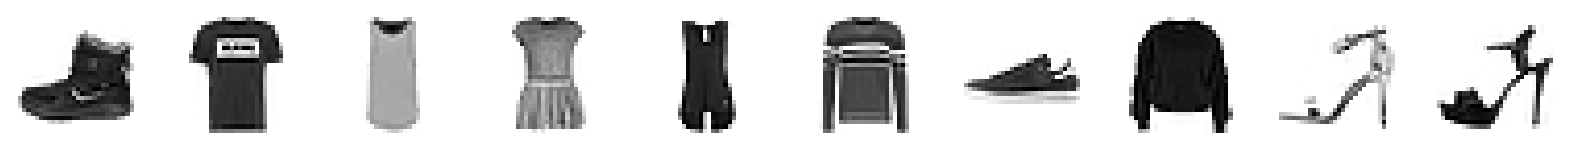

In [16]:
# Show some items of clothing from the training set
display(x_train)

## 2. Build the variational autoencoder <a name="build"></a>

## Mathematical Overview

In our original autoencoder model, we were projecting the images onto only a single, 2D point. However, we saw how we ran into several issues. To get around these, we are now going to embed our information in a *probability distribution*. Specifically, we are going to embed it in a *Multi-Variate Gaussian*. This has the form:

$$ \mathbf{z} \sim q_{\phi}(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mu_{\phi}(\mathbf{x}), \Sigma_{\phi}(\mathbf{x})) $$

Essentially, we are now saying that the encoder will give us a distribution and the model is parameterizing the mean and covariance functions. However, we will normally say we are embedding in an *isotropic* multi-variate Gaussian, meaning that $\Sigma$ is diagonal and the distribution can be written as:

$$ \mathcal{N}(\mu_{\phi}(\mathbf{x}), \Sigma_{\phi}(\mathbf{x})) = \mathcal{N}(\mu_{\phi}(\mathbf{x}), \sigma^2_{\phi}(\mathbf{x})\mathbf{I}_d) $$

This connection happends here:

$$ \texttt{x = layers.Flatten()(x)} $$
$$ \texttt{z\_mean = layers.Dense(EMBEDDING\_DIM, name="z\_mean")(x)} $$
$$ \texttt{z\_log\_var = layers.Dense(EMBEDDING\_DIM, name="z\_log\_var")(x)} $$

We see that we connect the flattened feature map twice to $\mu$ and $\log(\sigma^2)$.

Our model thus looks like: 

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/VAE.png' alt='VAE' width='500'>
</div>

However, we run into an issue: How do we do backpropagation? Well, we can use the *Reparameterization Trick* to sample in a way that allows us to manipulate the gradient graph. Namely, we can say:

$$ \mathbf{z} \sim \mathcal{N}(\mu_{\phi}(\mathbf{x}), \sigma^2_{\phi}(\mathbf{x})\mathbf{I}_d) = \mu_{\phi}(\mathbf{x}) + \sigma_{\phi}(\mathbf{x}) \odot \epsilon, \epsilon \sim \mathcal{N}(0, \mathbf{I}_d) $$

Essentially, when we want some *actual* value of $\mathbf{z}$, we sample $\epsilon \sim \mathcal{N}(0, \mathbf{I}_d)$ and construct it.

We will run one minor difference, namely that because the variance is always positive, $\sigma^2 >0$, we will use $\log(\sigma^2)$ so that our values map between $(-\infty, \infty)$. Thus, during sampling, we will use:

$$ \mathbf{z} = \mu_{\phi}(\mathbf{x}) + \exp(\log(\sigma^2_{\phi}(\mathbf{x})/2)) \odot \epsilon $$

To keep the distribution close to a normal one, we need to impose a second loss function. We will go with the *KL-Divergence* metric which tells us how close two distribution are. 

It has the form:

$$ D_{KL}(p||q) := \int_{\mathbb{R}^n} \log \left( \frac{p(x)}{q(x)} \right) p(x) dx $$ 

As a loss, we want this to be small, so we will use:

$$ \mathcal{L}_{KL}(X|\phi) = \frac{1}{|X|} \sum_{\mathbf{x} \in X} D_{KL} (q_{\phi}(\mathbf{z}|\mathbf{x})|| \mathcal{N}(0,\mathbf{I}_d)) $$ 

Our reconstruction loss could then be:

$$ \mathcal{L}_{MSE}(X|\theta, \phi) = \frac{1}{|X|} \sum_{\mathbf{x} \in X} \mathbb{E}_{\epsilon \sim \mathcal{N}(0, \mathbf{I}_d)} \left[ (\mathbf{x} - p_{\theta}(\mu_{\phi}(\mathbf{x}) + \sigma_{\phi}(\mathbf{x}) \odot \epsilon))^2 \right] $$

Finally, in this notebook, we have a special case of the KL-Divergence and it can be written as:

$$ D_{KL} (q_{\phi}(\mathbf{z}|\mathbf{x}) || \mathcal{N}(0, \mathbf{I}_d)) =- \frac{1}{2} \sum_d (1 + \log(\sigma^2_{\phi}(\mathbf{x})) -\mu_{\phi}(\mathbf{x})^2 - \sigma^2_{\phi}(\mathbf{x})) $$

Giving us a KL-Divergence loss function:

$$ \mathcal{L}_{KL}(X|\phi) = \frac{1}{|X|} \sum_{\mathbf{x} \in X} \left[ - \frac{1}{2} \sum_d (1 + \log(\sigma^2_{\phi}(\mathbf{x})) -\mu_{\phi}(\mathbf{x})^2 - \sigma^2_{\phi}(\mathbf{x})) \right] $$

Our total loss will then be:

$$ \mathcal{L} = \beta \mathcal{L}_{MSE} + \mathcal{L}_{KL} $$

In [17]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # Special form of z (pg. 77)

In [18]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x) # Instead of connecting the flattened layer to the latent space, we connect it to the mean and log(var) 
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var]) # Gives us a z

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder") # Encoder model takes as input the encoder_input out outputs a tuple
# of z_mean, z_log_var, and the sampled z
encoder.summary()

2023-07-06 17:11:40.886027: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-07-06 17:11:40.886246: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: OPH-M-DF98PS3L
2023-07-06 17:11:40.886293: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: OPH-M-DF98PS3L
2023-07-06 17:11:40.886962: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-07-06 17:11:40.887628: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.105.17
2023-07-06 17:11:40.887678: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 525.105.17 does not match DSO version 525.125.6 -- cannot find working devices in this configuration
2023-07-06 17:11:40.889390: I tensorflow/core/platform/cpu_feature_guard.cc:19

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

In [19]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       18464 

In [35]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA # Hyperparameter to weight the reconstruction loss
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [36]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [37]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [38]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [39]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

2023-07-06 20:08:43.363196: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


Epoch 1/5
600/600 [==============================] - 201s 327ms/step - total_loss: 138.9792 - reconstruction_loss: 134.2591 - kl_loss: 4.7201 - val_loss: 138.5007 - val_reconstruction_loss: 133.5348 - val_kl_loss: 4.9660
Epoch 2/5
600/600 [==============================] - 179s 299ms/step - total_loss: 134.5337 - reconstruction_loss: 129.6557 - kl_loss: 4.8780 - val_loss: 136.6257 - val_reconstruction_loss: 131.6954 - val_kl_loss: 4.9303
Epoch 3/5
600/600 [==============================] - 179s 299ms/step - total_loss: 133.4165 - reconstruction_loss: 128.4758 - kl_loss: 4.9407 - val_loss: 135.8710 - val_reconstruction_loss: 130.8071 - val_kl_loss: 5.0639
Epoch 4/5
600/600 [==============================] - 179s 299ms/step - total_loss: 132.7450 - reconstruction_loss: 127.7360 - kl_loss: 5.0090 - val_loss: 135.1180 - val_reconstruction_loss: 129.9477 - val_kl_loss: 5.1702
Epoch 5/5
600/600 [==============================] - 179s 298ms/step - total_loss: 132.3745 - reconstruction_loss: 1

In [40]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [41]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 11s 62ms/step
Example real clothing items


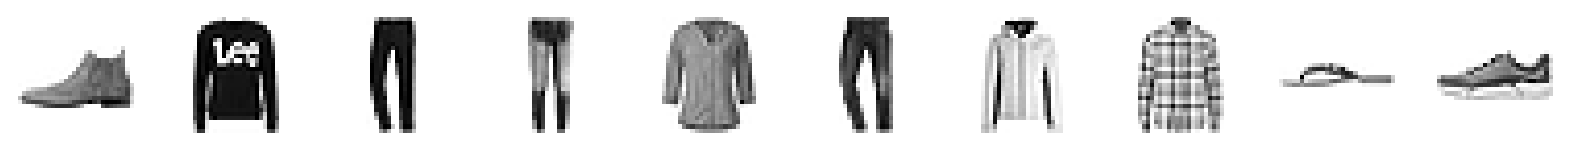

Reconstructions


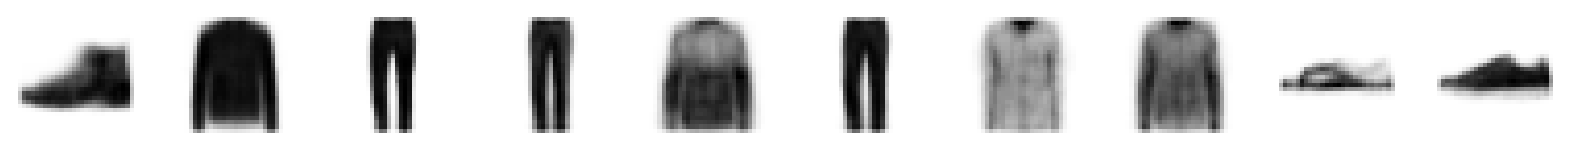

In [42]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images) # Predict is the call function defined above.
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Embed using the encoder <a name="encode"></a>

In [43]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 3s 13ms/step


In [44]:
# Some examples of the embeddings
print(z[:10])

[[ 1.1886274  -0.4971461 ]
 [-0.33269098  1.2417806 ]
 [-2.4843445  -1.0975764 ]
 [-1.302515   -1.205018  ]
 [-0.01586482  0.10006458]
 [-1.6840839  -0.2824782 ]
 [-0.20486793 -0.86259216]
 [-0.1048544  -0.05675144]
 [ 2.2926798  -1.785492  ]
 [ 2.3319263   0.14950216]]


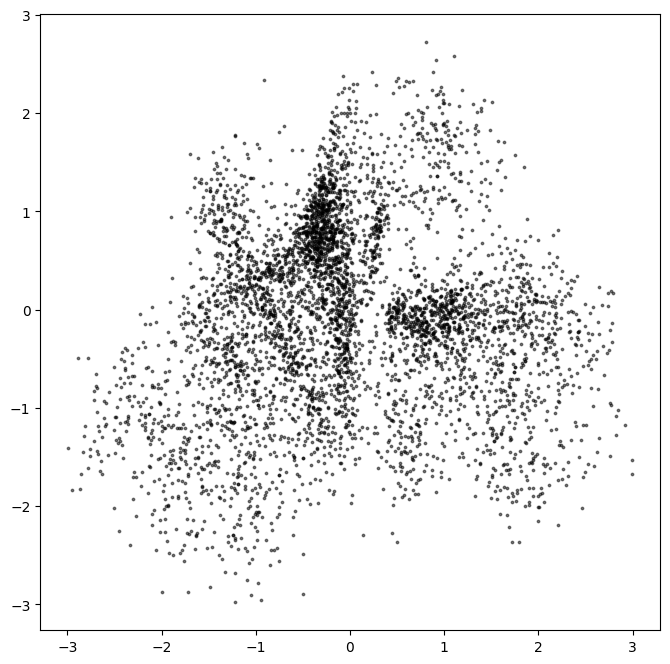

In [45]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. Generate using the decoder <a name="decode"></a>

In [46]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [47]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 1s 661ms/step


In [48]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

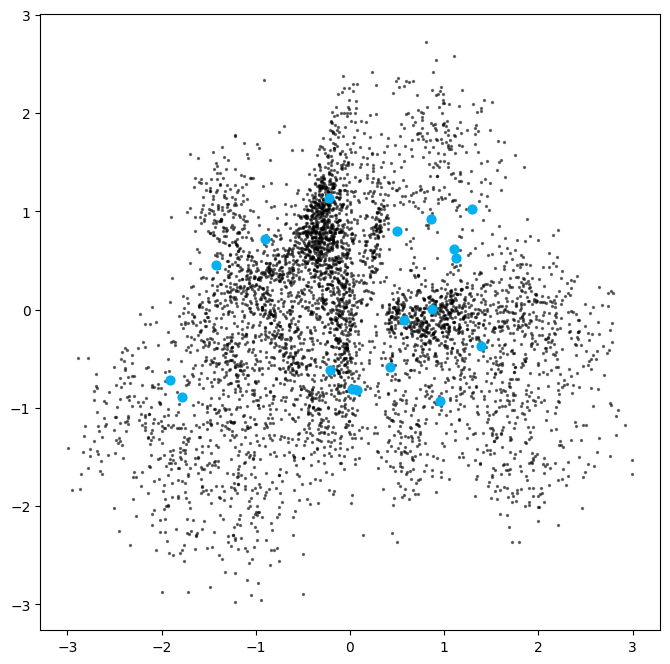

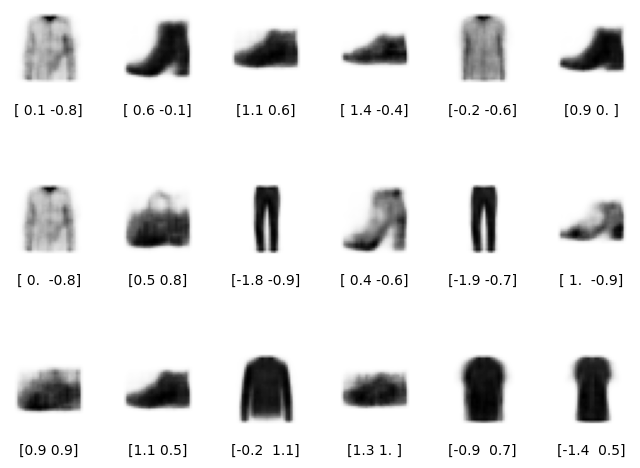

In [49]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. Explore the latent space <a name="explore"></a>

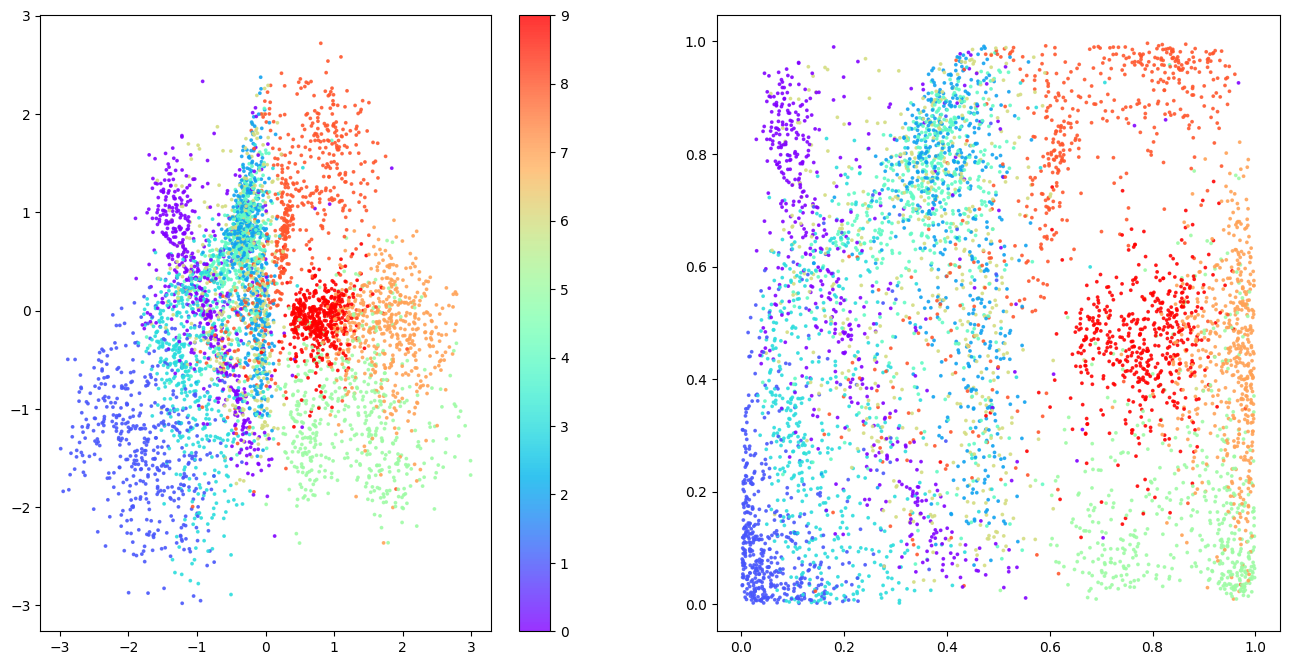

In [50]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

8/8 [==============================] - 0s 38ms/step


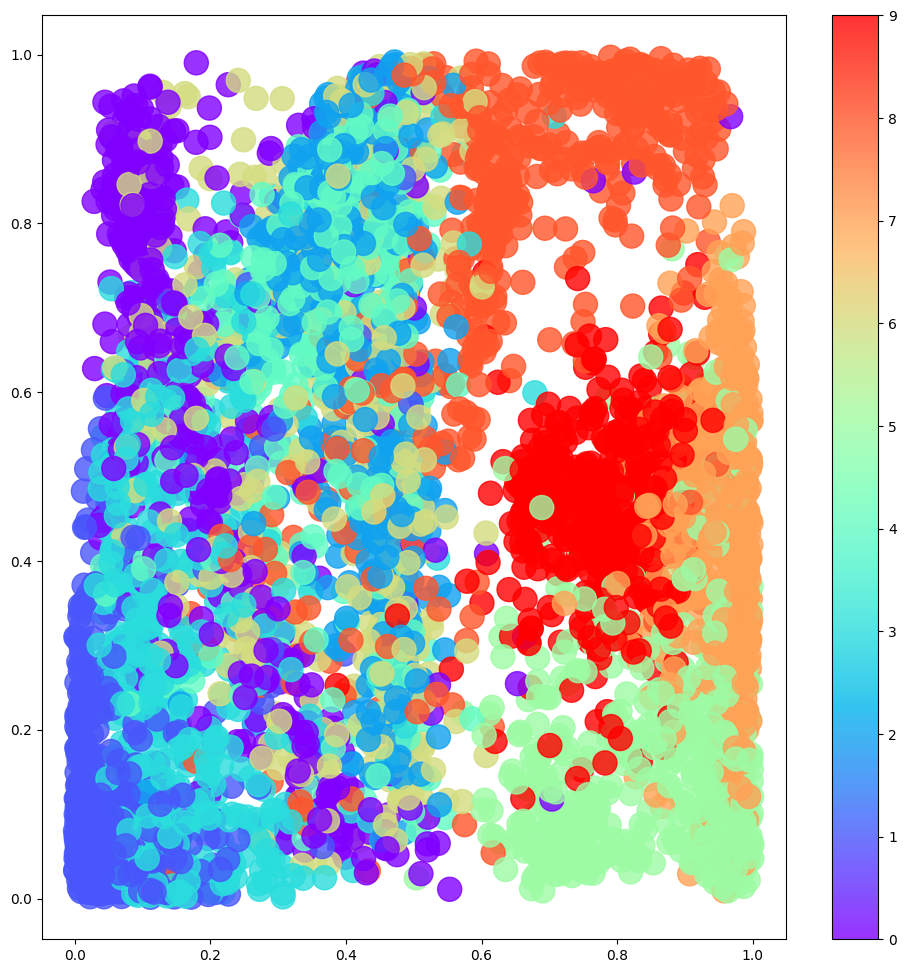

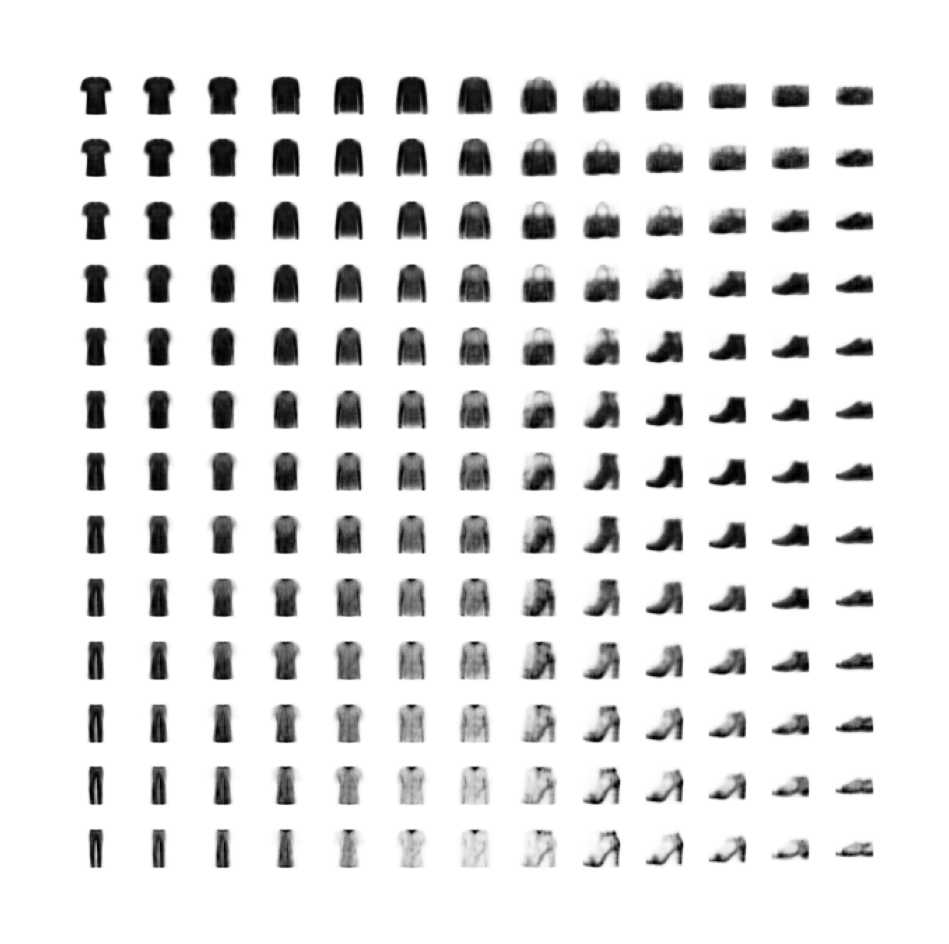

In [51]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")